
### HMM
This is a simplified version of CategoricalHMM. I chose to do a heat map at the end to visualize the models results

Source: I used this guide as a source to create this model: https://www.geeksforgeeks.org/hidden-markov-model-in-machine-learning/
1. Define the state space and observation space

State space: Blood glucose levels, with different categories such as high, normal, and low
Observations: Insulin on board (IOB)
Transitions: Transitions between normal, high, and low based on IOB

### Pre Process Data

In [9]:
import pandas as pd
import numpy as np

# Load the data
file_path = '../data/interim/2024-10-24_500030__timeInter5mins_dayStart4hrs_minCarb5g_5hrMealW.csv'
df = pd.read_csv(file_path)

# Define BG thresholds
low_bg = 70
high_bg = 180

# Define IOB thresholds (assuming dose_units represents IOB)
low_iob = 0
medium_iob = 2
high_iob = 5

# Classify BG into states
def classify_bg(bgl):
    if pd.isna(bgl):
        return np.nan
    elif bgl < low_bg:
        return 0  # Low
    elif bgl <= high_bg:
        return 1  # Normal
    else:
        return 2  # High

df['bg_state'] = df['bgl'].apply(classify_bg)

# Classify IOB into observations
def classify_iob(iob):
    if pd.isna(iob) or iob == 0:
        return 0  # No IOB
    elif iob <= medium_iob:
        return 1  # Low IOB
    elif iob <= high_iob:
        return 2  # Medium IOB
    else:
        return 3  # High IOB

df['iob_obs'] = df['dose_units'].apply(classify_iob)


Initialize State Probabilities -
Based on the BG state, calculate probability of each state to start on low, high, or normal range.

In [10]:
# Initial state probabilities
initial_state_counts = df['bg_state'].value_counts(normalize=True)
initial_probs = initial_state_counts.sort_index().values  # Ensure order matches state indices


Compute Transition Probabilities - Using the values found in the previous, and introducing IOB, find the likelihood of transitions.

In [ ]:
df_clean = df.dropna(subset=['bg_state'])

states = df_clean['bg_state'].tolist()

# Initialize transition matrix
num_states = 3  # Low, Normal, High
transition_matrix = np.zeros((num_states, num_states))

# Populate transition counts
for (s1, s2) in zip(states[:-1], states[1:]):
    transition_matrix[int(s1), int(s2)] += 1

# Convert counts to probabilities
transition_probs = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)


In [12]:
# Remove NaN values
df_emission = df.dropna(subset=['bg_state', 'iob_obs'])

# Initialize emission matrix
num_observations = 4  # No IOB, Low IOB, Medium IOB, High IOB
emission_matrix = np.zeros((num_states, num_observations))

# Populate emission counts
for state, obs in zip(df_emission['bg_state'], df_emission['iob_obs']):
    emission_matrix[int(state), int(obs)] += 1

# Convert counts to probabilities
emission_probs = emission_matrix / emission_matrix.sum(axis=1, keepdims=True)


### Create and train the model

In [14]:
from hmmlearn import hmm

# Define the model
model = hmm.CategoricalHMM(n_components=num_states, n_iter=100, tol=0.01, init_params='')

# Set the estimated parameters
model.startprob_ = initial_probs
model.transmat_ = transition_probs
model.emissionprob_ = emission_probs

# Prepare the observation sequence
observations = df_emission['iob_obs'].astype(int).values.reshape(-1, 1)

# Fit the model (optional, since we already set parameters)
# model.fit(observations)

# Decode the hidden states
logprob, hidden_states = model.decode(observations, algorithm="viterbi")

# Add hidden states to DataFrame
df_emission['predicted_bg_state'] = hidden_states


/var/folders/by/vymnlz4s25b64sgh9j3_nmb40000gn/T/ipykernel_48456/663737217.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emission['predicted_bg_state'] = hidden_states


In [22]:
# Calculate accuracy
accuracy = (df_emission['bg_state'] == df_emission['predicted_bg_state']).mean()
print(f"Model Accuracy: {accuracy:.2f}")



Model Accuracy: 0.91


In [17]:
# Separate data where IOB is present
df_iob_present = df_emission[df_emission['iob_obs'] > 0]

# Extract states and observations
states_iob = df_iob_present['bg_state'].tolist()

# Initialize transition matrix for IOB present
transition_matrix_iob = np.zeros((num_states, num_states))

# Populate transition counts
for (s1, s2) in zip(states_iob[:-1], states_iob[1:]):
    transition_matrix_iob[int(s1), int(s2)] += 1

# Convert counts to probabilities
transition_probs_iob = transition_matrix_iob / transition_matrix_iob.sum(axis=1, keepdims=True)

print("Transition Probabilities with IOB present:")
print(transition_probs_iob)


Transition Probabilities with IOB present:
[[0.         1.         0.        ]
 [0.01333333 0.89142857 0.0952381 ]
 [0.02739726 0.65753425 0.31506849]]


### Display the data

I used a heat map to show the difference, and explained a bit below.

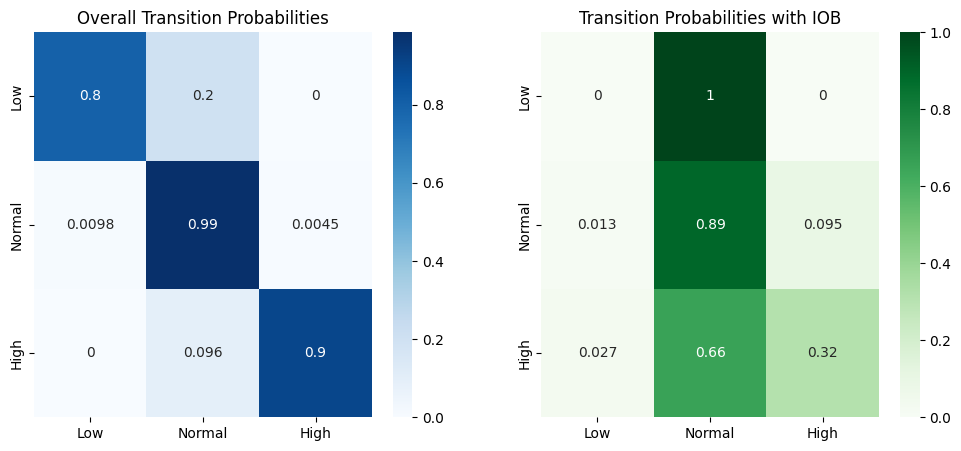

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for transition probabilities
trans_probs_df = pd.DataFrame(transition_probs, columns=['Low', 'Normal', 'High'], index=['Low', 'Normal', 'High'])
trans_probs_iob_df = pd.DataFrame(transition_probs_iob, columns=['Low', 'Normal', 'High'], index=['Low', 'Normal', 'High'])

# Plot heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(trans_probs_df, annot=True, cmap='Blues')
plt.title('Overall Transition Probabilities')

plt.subplot(1, 2, 2)
sns.heatmap(trans_probs_iob_df, annot=True, cmap='Greens')
plt.title('Transition Probabilities with IOB')

plt.show()

Results: This is the likelihood that a state will transition from a certain state (Y axis) to another state (X axis) when IOB. The first state is given as reference.